In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
#upload your kaggle token here
files.upload()

In [1]:
! mkdir ~/.kaggle

In [2]:
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download williamhyun/amazon-bin-image-dataset-536434-images-224x224

100% 3.49G/3.50G [00:36<00:00, 155MB/s]
100% 3.50G/3.50G [00:36<00:00, 104MB/s]


In [ ]:
!unzip amazon-bin-image-dataset-536434-images-224x224.zip

In [6]:
%rm amazon-bin-image-dataset-536434-images-224x224.zip

In [7]:
import matplotlib.pyplot as plt


In [8]:
import sqlite3
import pandas as pd
import json

In [9]:
def importdb(db):
     conn = sqlite3.connect(db)
     c = conn.cursor()
     meta_df =pd.read_sql("Select * from metadata",conn)
     return meta_df

In [71]:
meta_df = importdb('/content/metadata.db')

In [72]:
meta_df

,name,metadata
0,00001.jpg,"{""BIN_FCSKU_DATA"": {""B000C33MI2"": {""asin"": ""B0..."
1,1.jpg,"{""BIN_FCSKU_DATA"": {}, ""EXPECTED_QUANTITY"": 0,..."
2,00002.jpg,"{""BIN_FCSKU_DATA"": {""0307981584"": {""asin"": ""03..."
3,2.jpg,"{""BIN_FCSKU_DATA"": {}, ""EXPECTED_QUANTITY"": 0,..."
4,00003.jpg,"{""BIN_FCSKU_DATA"": {""0307981584"": {""asin"": ""03..."
...,...,...
536429,535230.jpg,"{""BIN_FCSKU_DATA"": {""0321897420"": {""asin"": ""03..."
536430,535231.jpg,"{""BIN_FCSKU_DATA"": {""0321897420"": {""asin"": ""03..."
536431,535232.jpg,"{""BIN_FCSKU_DATA"": {""B015TC63LI"": {""asin"": ""B0..."
536432,535233.jpg,"{""BIN_FCSKU_DATA"": {""B015TC63LI"": {""asin"": ""B0..."


In [12]:
def ConvertToDict(row):
  try:
    row["metadata"] = json.loads(row["metadata"])
  except:
    print(row["name"],'has invalid label')
    print(type({row["metadata"]}))
  return row


In [73]:
meta_df['metadata'] = meta_df['metadata'].apply(lambda x: json.loads(x)['EXPECTED_QUANTITY'])

In [74]:
meta_df.rename(columns={'metadata': 'EXPECTED_QUANTITY'}, inplace = True)
meta_df.head()

,name,EXPECTED_QUANTITY
0,00001.jpg,12
1,1.jpg,0
2,00002.jpg,17
3,2.jpg,0
4,00003.jpg,16


In [15]:
meta_df['name'] = meta_df['name'].apply(lambda x: x.split('.')[0])

In [16]:
meta_df['name'] = meta_df['name'].astype(int)

In [17]:
meta_df

,name,EXPECTED_QUANTITY
0,1,12
1,1,0
2,2,17
3,2,0
4,3,16
...,...,...
536429,535230,3
536430,535231,4
536431,535232,3
536432,535233,2


In [18]:
meta_df['EXPECTED_QUANTITY'].value_counts()

3      90258
4      80750
2      77063
5      62648
6      46058
       ...  
209        1
207        1
171        1
100        1
185        1
Name: EXPECTED_QUANTITY, Length: 140, dtype: int64

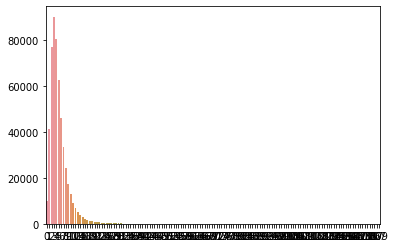

In [19]:
import seaborn as sns
sns.barplot(y=meta_df.EXPECTED_QUANTITY.value_counts().values,x=meta_df.EXPECTED_QUANTITY.value_counts().keys());

In [20]:
meta_df[meta_df.EXPECTED_QUANTITY.isin(list(meta_df['EXPECTED_QUANTITY'].value_counts().sort_values(ascending=False)[:10].keys()))]['EXPECTED_QUANTITY'].value_counts()

3     90258
4     80750
2     77063
5     62648
6     46058
1     41347
7     33684
8     24219
9     17298
10    12823
Name: EXPECTED_QUANTITY, dtype: int64

In [75]:
subset=meta_df[meta_df.EXPECTED_QUANTITY.isin([0,1,2,3,4])]

In [22]:
subset=subset[subset.name>50000]

In [23]:
subset.sample(10)

,name,EXPECTED_QUANTITY
442413,441214,3
188448,187249,3
420531,419332,1
133502,132303,3
91337,90138,4
224809,223610,2
108048,106849,3
362459,361260,2
239380,238181,4
433566,432367,2


In [24]:
%cp /content/bin-images-224x224/bin-images-224x224/452138.jpg ./452138.jpg

In [25]:
import os

In [26]:
os.listdir('/content/bin-images-224x224')

['bin-images-224x224']

In [27]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536434 entries, 0 to 536433
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   name               536434 non-null  int64
 1   EXPECTED_QUANTITY  536434 non-null  int64
dtypes: int64(2)
memory usage: 8.2 MB


In [28]:
%cp /content/drive/MyDrive/FreelancerFiles/'sharing files pytorch'/* ./

In [29]:
from torchvision.models import resnet34
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import cv2
import numpy as np


In [ ]:
cuda=True
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
 
#LEARNING_RATE = 0.001
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(params_to_update, lr= LEARNING_RATE)
if cuda: 
  model.cuda()


In [ ]:
model.load_state_dict(torch.load('/content/Resnet34v2.pth'))
model.eval()

In [59]:
loc = '/content/bin-images-224x224/bin-images-224x224/452138.jpg'
img = cv2.imread(loc)
#img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
img = torch.tensor(np.moveaxis(img,-1,0)).float()
img = img.reshape(1,3,224,224)
#other = torch.randn((), dtype=torch.float)

num = np.argmax(model(img.cuda()).cpu().detach().numpy())

In [60]:
num

3

In [61]:
def test_acc(loc,label):
  img = cv2.imread(loc)
  #img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
  img = torch.tensor(np.moveaxis(img,-1,0)).float()
  img = img.reshape(1,3,224,224)
  #other = torch.randn((), dtype=torch.float)

  num = np.argmax(model(img.cuda()).cpu().detach().numpy())
  return int(num==label)


In [40]:
test_acc('/content/452138.jpg',3)

1

In [65]:
Sub = subset.sample(5000)

In [44]:
from tqdm.auto import tqdm

In [66]:
total=0
for img_id , label in tqdm(Sub.values):
  loc = f'/content/bin-images-224x224/bin-images-224x224/{img_id}.jpg'
  total+=test_acc(loc,label)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [67]:
print(f'test acc is {round(((total)/len(Sub))*100,2)}%')

test acc is 43.9%


In [68]:
Sub.EXPECTED_QUANTITY.value_counts()

3    1473
4    1346
2    1324
1     685
0     172
Name: EXPECTED_QUANTITY, dtype: int64

In [70]:
meta_df[meta_df['EXPECTED_QUANTITY']==0]

,name,EXPECTED_QUANTITY
1,1,0
3,2,0
5,3,0
7,4,0
9,5,0
...,...,...
536260,535061,0
536263,535064,0
536295,535096,0
536358,535159,0


In [76]:
subset.EXPECTED_QUANTITY.value_counts()

3    90258
4    80750
2    77063
1    41347
0     9901
Name: EXPECTED_QUANTITY, dtype: int64

In [77]:
meta_0=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==0].values[:9900],columns=meta_df.columns,index=np.arange(0,9900))
meta_1=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==1].values[:9900],columns=meta_df.columns,index=np.arange(0,9900))
meta_2=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==2].values[:9900],columns=meta_df.columns,index=np.arange(0,9900))
meta_3=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==3].values[:9900],columns=meta_df.columns,index=np.arange(0,9900))
meta_4=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==4].values[:9900],columns=meta_df.columns,index=np.arange(0,9900))

In [316]:
dataset=meta_4.append(meta_3.append(meta_2.append(meta_0.append(meta_1,ignore_index=True),ignore_index=True),ignore_index=True),ignore_index=True)

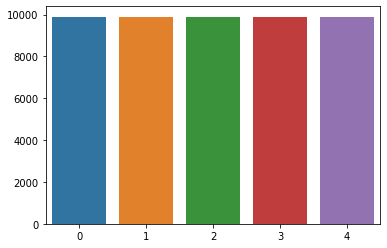

In [317]:
sns.barplot(y=dataset.EXPECTED_QUANTITY.value_counts().values,x=dataset.EXPECTED_QUANTITY.value_counts().keys());

In [318]:
dataset=dataset.sample(frac=1)
dataset.index=np.arange(0,len(dataset))

In [319]:
dataset['name'] = dataset['name'].apply(lambda x: x.split('.')[0])

In [315]:
dataset['name'] = dataset['name'].apply(lambda x: f'/content/bin-images-224x224/bin-images-224x224/{x}')

In [320]:
dataset

,name,EXPECTED_QUANTITY
0,57011,3
1,02948,4
2,53623,3
3,59030,4
4,27238,3
...,...,...
49495,37738,4
49496,25881,3
49497,16716,1
49498,20683,3


In [321]:
%matplotlib inline
import sqlite3
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
import PIL
from tqdm.auto import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import cupy as cp
#import cucim
import json
from sklearn.decomposition import PCA
from skimage.feature import hog,blob_log
from keras.preprocessing.image import ImageDataGenerator
from scipy import signal
from sklearn.model_selection import cross_val_score
from tensorflow.keras.utils import to_categorical


In [322]:
train_features, test_features, train_labels, test_labels = train_test_split(dataset['name'].to_numpy(), dataset['EXPECTED_QUANTITY'].to_numpy().tolist(), test_size=0.2, random_state=42,stratify=dataset['EXPECTED_QUANTITY'])
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.1, random_state=42,stratify=train_labels)


In [329]:
train_features

array(['57083', '22016', '46679', ..., '163396', '90476', '63329'],
      dtype=object)

In [372]:
BATCH_SIZE = 128
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import torch.nn.functional as F

class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    img=cv2.imread(f'/content/bin-images-224x224/bin-images-224x224/'+self.feat_arr[index]+'.jpg')
    return torch.tensor(np.moveaxis(img,-1,0)).float(),torch.tensor((self.label[index]))
  def __len__(self):
    return len(self.feat_arr)

train_dataloader = DataLoader(dataset(train_features,train_labels),batch_size = BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset(val_features,val_labels),batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset(test_features,test_labels),batch_size = BATCH_SIZE, shuffle=True)

In [373]:
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


In [374]:
LEARNING_RATE = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr= LEARNING_RATE)

In [375]:
def Temp_func():
  train_accu = []
  train_losses = []
  eval_losses=[]
  eval_accu=[]

  def train_model(model,epoch,train_features,train_labels,val_features,val_labels):
    print('\nEpoch : %d'%epoch)
    
    model.train()
  
    running_loss=0
    correct=0
    total=0
    train_batches = list(zip(train_features,train_labels))
    val_batches = list(zip(val_features,val_labels))
    for train_index in tqdm(range(len(train_batches))):
      inputs,labels=train_batches[train_index]
      loc = inputs
      img = cv2.imread(loc)
      img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
      img = torch.tensor(np.moveaxis(img,-1,0)).float()
      inputs = img.reshape(1,3,224,224)
      labels = torch.tensor(labels).reshape(1,5)
      if cuda:
        inputs,labels=inputs.cuda(),labels.cuda()
      
      optimizer.zero_grad()

      outputs=model(inputs)
      #print(outputs)
      #print(labels)
      loss=loss_fn(outputs,labels)
      loss.backward()
      optimizer.step()
  
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      #print(predicted)
      #print(torch.tensor(np.argmax(labels.cpu().detach().numpy())))
      total += labels.size(0)


      correct += predicted.eq(torch.tensor(np.argmax(labels.cpu().detach().numpy()))).sum().item()
      #print(correct)
        
    train_loss=running_loss/len(train_batches)
    accu=correct/total
    
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,accu),end=" | ")


    model.eval()
    running_loss=0
    correct=0
    total=0
    
    with torch.no_grad():
      for val_index in tqdm(range(len(train_batches))):
        val_inputs,val_labels=train_batches[val_batches]
        loc = val_inputs
        img = cv2.imread(loc)
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
        img = torch.tensor(np.moveaxis(img,-1,0)).float()
        val_inputs = img.reshape(1,3,224,224)
        val_labels = torch.tensor(val_labels).reshape(1,5)
        if cuda:
          val_inputs,val_labels = val_inputs.cuda(),val_labels.cuda()
        
        outputs=model(val_inputs)

        loss= loss_fn(outputs,val_labels)
        running_loss+=loss.item()
        
        _, predicted = outputs.max(1)
        total += val_labels.size(0)
        correct += predicted.eq(torch.tensor(np.argmax(val_labels.cpu().detach().numpy()))).sum().item()
    
    val_loss=running_loss/len(val_batches)
    accu=correct/total
  
    eval_losses.append(val_loss)
    eval_accu.append(accu)
  
    print('Val Loss: %.3f | Validation Accuracy: %.3f'%(val_loss,accu))

In [376]:
train_accu = []
train_losses = []
eval_losses=[]
eval_accu=[]

def train_model(model,epoch,train_dataloader,val_dataloader):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for inputs,labels in tqdm(train_dataloader):
    if cuda:
      inputs,labels=inputs.cuda(),labels.cuda()
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(train_dataloader)
  accu=correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,accu),end=" | ")


  model.eval()
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for val_inputs,val_labels in val_dataloader:

      if cuda:
        val_inputs,val_labels = val_inputs.cuda(),val_labels.cuda()
       
      outputs=model(val_inputs)
 
      loss= loss_fn(outputs,val_labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += val_labels.size(0)
      correct += predicted.eq(val_labels).sum().item()
   
  val_loss=running_loss/len(val_dataloader)
  accu=correct/total
 
  eval_losses.append(val_loss)
  eval_accu.append(accu)
 
  print('Val Loss: %.3f | Validation Accuracy: %.3f'%(val_loss,accu))

In [377]:
EPOCHS=10
for epoch in range(1,EPOCHS+1): 
  train_model(model,epoch,train_dataloader,val_dataloader)


Epoch : 1


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 1.036 | Train Accuracy: 0.521 | Val Loss: 0.973 | Validation Accuracy: 0.546

Epoch : 2


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.946 | Train Accuracy: 0.561 | Val Loss: 1.123 | Validation Accuracy: 0.485

Epoch : 3


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.913 | Train Accuracy: 0.577 | Val Loss: 0.931 | Validation Accuracy: 0.568

Epoch : 4


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.887 | Train Accuracy: 0.591 | Val Loss: 0.905 | Validation Accuracy: 0.584

Epoch : 5


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.860 | Train Accuracy: 0.606 | Val Loss: 0.899 | Validation Accuracy: 0.588

Epoch : 6


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.838 | Train Accuracy: 0.614 | Val Loss: 0.933 | Validation Accuracy: 0.576

Epoch : 7


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.807 | Train Accuracy: 0.630 | Val Loss: 0.903 | Validation Accuracy: 0.579

Epoch : 8


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.772 | Train Accuracy: 0.648 | Val Loss: 1.011 | Validation Accuracy: 0.540

Epoch : 9


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.726 | Train Accuracy: 0.669 | Val Loss: 1.002 | Validation Accuracy: 0.566

Epoch : 10


  0%|          | 0/279 [00:00<?, ?it/s]

Train Loss: 0.667 | Train Accuracy: 0.700 | Val Loss: 0.985 | Validation Accuracy: 0.582


In [378]:
y_pred=[]
y_true=[]
def test_model(model,test_dataloader):
  model.eval()
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for test_inputs,test_labels in test_dataloader:

      if cuda:
        test_inputs,test_labels = test_inputs.cuda(),test_labels.cuda()
       
      outputs=model(test_inputs)
 
      loss= loss_fn(outputs,test_labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += test_labels.size(0)
      correct += predicted.eq(test_labels).sum().item()
   
      test_loss=running_loss/len(test_dataloader)
      accu=correct/total
 
      y_pred.extend((torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()) # Save Prediction
      test_labels = test_labels.data.cpu().numpy()
      y_true.extend(test_labels) # Save Truth
 
  print('test Accuracy: %.3f'%(accu))

In [379]:
y_pred=[]
y_true=[]
test_model(model,test_dataloader)

test Accuracy: 0.593


In [381]:
torch.save(model.state_dict(),'/content/Resnet34v3.pth')

In [382]:
%mkdir /content/drive/MyDrive/FreelancerFiles/Techno


In [383]:
%cp ./Resnet34v3.pth /content/drive/MyDrive/FreelancerFiles/Techno/Resnet34v3.pth

In [384]:
meta_df

,name,EXPECTED_QUANTITY
0,00001.jpg,12
1,1.jpg,0
2,00002.jpg,17
3,2.jpg,0
4,00003.jpg,16
...,...,...
536429,535230.jpg,3
536430,535231.jpg,4
536431,535232.jpg,3
536432,535233.jpg,2


In [ ]:
Sub = subset.sample(5000)

In [385]:
meta_0=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==0].values[9900:],columns=meta_df.columns,index=np.arange(0,len(meta_df[meta_df.EXPECTED_QUANTITY==0].values[9900:])))
meta_1=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==1].values[9900:],columns=meta_df.columns,index=np.arange(0,len(meta_df[meta_df.EXPECTED_QUANTITY==1].values[9900:])))
meta_2=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==2].values[9900:],columns=meta_df.columns,index=np.arange(0,len(meta_df[meta_df.EXPECTED_QUANTITY==2].values[9900:])))
meta_3=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==3].values[9900:],columns=meta_df.columns,index=np.arange(0,len(meta_df[meta_df.EXPECTED_QUANTITY==3].values[9900:])))
meta_4=pd.DataFrame(meta_df[meta_df.EXPECTED_QUANTITY==4].values[9900:],columns=meta_df.columns,index=np.arange(0,len(meta_df[meta_df.EXPECTED_QUANTITY==4].values[9900:])))

In [416]:
subset =meta_4.append(meta_3.append(meta_2.append(meta_0.append(meta_1,ignore_index=True),ignore_index=True),ignore_index=True),ignore_index=True)

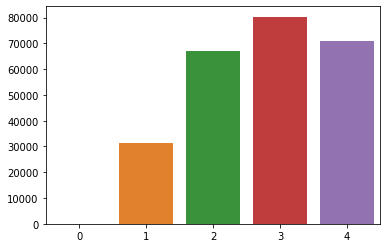

In [417]:
sns.barplot(y=subset.EXPECTED_QUANTITY.value_counts().values,x=subset.EXPECTED_QUANTITY.value_counts().keys());

In [418]:
subset

,name,EXPECTED_QUANTITY
0,64506.jpg,4
1,64510.jpg,4
2,64515.jpg,4
3,64522.jpg,4
4,64526.jpg,4
...,...,...
249814,535146.jpg,1
249815,535178.jpg,1
249816,535192.jpg,1
249817,535196.jpg,1


In [437]:
subset = subset.sample(1000)

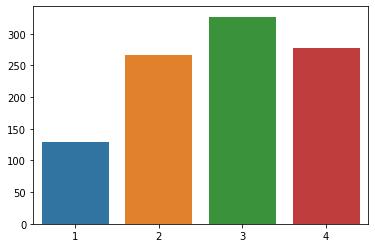

In [438]:
sns.barplot(y=subset.EXPECTED_QUANTITY.value_counts().values,x=subset.EXPECTED_QUANTITY.value_counts().keys());

In [439]:
subset

,name,EXPECTED_QUANTITY
92733,188420.jpg,3
94790,200728.jpg,3
103474,252730.jpg,3
134416,436076.jpg,3
65542,500366.jpg,4
...,...,...
207080,456098.jpg,2
125517,382143.jpg,3
23834,223620.jpg,4
164835,163507.jpg,2


In [440]:
total=0
for img_id , label in tqdm(subset.values):
  loc = f'/content/bin-images-224x224/bin-images-224x224/{img_id}'
  total+=test_acc(loc,label)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [441]:
print(f'test acc is {round(((total)/len(subset))*100,2)}%')

test acc is 42.6%


In [442]:
subset.sample(5)

,name,EXPECTED_QUANTITY
89409,168942.jpg,3
240147,407816.jpg,1
140427,471635.jpg,3
151930,72668.jpg,2
143993,492209.jpg,3


In [431]:
%cp /content/bin-images-224x224/bin-images-224x224/252378.jpg ./252378.jpg

In [433]:
%cp /content/bin-images-224x224/bin-images-224x224/451878.jpg ./451878.jpg

In [444]:
%cp /content/bin-images-224x224/bin-images-224x224/407816.jpg ./407816.jpg